## IBM Data Science Professional

Applied Data Science Capstone, Chris Gray, September 2020

First, let's import the necessary libraries...

In [1]:
import itertools
import numpy as np
import pylab as pl
import pandas as pd

### Data understanding:
In this phase, you need to collect or extract the dataset from various sources such as csv file or SQL database. Then, you need to determine the attributes (columns) that you will use to train your machine learning model. Also, you will assess the condition of chosen attributes by looking for trends, certain patterns, skewed information, correlations, and so on.

In [2]:
!wget -O Data-Collisions.csv https://raw.githubusercontent.com/chrisgray40/Coursera_Capstone/master/Data-Collisions.csv
df = pd.read_csv('Data-Collisions.csv', error_bad_lines=False)

--2020-09-11 18:43:15--  https://raw.githubusercontent.com/chrisgray40/Coursera_Capstone/master/Data-Collisions.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72431093 (69M) [text/plain]
Saving to: ‘Data-Collisions.csv’

100%[======================================>] 72,431,093   169MB/s   in 0.4s   

2020-09-11 18:43:16 (169 MB/s) - ‘Data-Collisions.csv’ saved [72431093/72431093]



/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()
df.shape

(194673, 37)

Let's start by looking at Address type. Does this have any impact on our Severity Score?

In [4]:
# Address Type
df['ADDRTYPE'].value_counts(dropna=False)


Block           126926
Intersection     65070
NaN               1926
Alley              751
Name: ADDRTYPE, dtype: int64

In [5]:
df.groupby(['ADDRTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

ADDRTYPE      SEVERITYCODE
Alley         1               0.890812
              2               0.109188
Block         1               0.762885
              2               0.237115
Intersection  1               0.572476
              2               0.427524
Name: SEVERITYCODE, dtype: float64

Yes, it does! Intersections are much more dangerous than alleys. This could easily be a function of speed.

Let's move on to Collision Type

In [6]:
# Collision Type
df['COLLISIONTYPE'].value_counts(dropna=False)

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
NaN            4904
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

In [7]:
df.groupby(['COLLISIONTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

COLLISIONTYPE  SEVERITYCODE
Angles         1               0.607083
               2               0.392917
Cycles         2               0.876085
               1               0.123915
Head On        1               0.569170
               2               0.430830
Left Turn      1               0.605123
               2               0.394877
Other          1               0.742142
               2               0.257858
Parked Car     1               0.944527
               2               0.055473
Pedestrian     2               0.898305
               1               0.101695
Rear Ended     1               0.569639
               2               0.430361
Right Turn     1               0.793978
               2               0.206022
Sideswipe      1               0.865334
               2               0.134666
Name: SEVERITYCODE, dtype: float64

Definite trends with Collision type. It appears that collisions at angles, head on, left turn, and rear end lead to the most severe crashes.
Cycles, sideswipes, etc are less dangerous

In [8]:
# Person Count
df['PERSONCOUNT'].value_counts(dropna=False)

2     114231
3      35553
4      14660
1      13154
5       6584
0       5544
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         1
48         1
53         1
54         1
81         1
Name: PERSONCOUNT, dtype: int64

Pretty big spread of persons here. Let's group into 1, 2, 3, 4, and 5+ 

In [9]:
df['PERSONCOUNT'].where(df['PERSONCOUNT'] < 5,5,inplace=True)
df['PERSONCOUNT'].value_counts(dropna=False)

2    114231
3     35553
4     14660
1     13154
5     11531
0      5544
Name: PERSONCOUNT, dtype: int64

In [10]:
df.groupby(['PERSONCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

PERSONCOUNT  SEVERITYCODE
0            1               0.682179
             2               0.317821
1            1               0.749430
             2               0.250570
2            1               0.756537
             2               0.243463
3            1               0.621382
             2               0.378618
4            1               0.570600
             2               0.429400
5            1               0.517561
             2               0.482439
Name: SEVERITYCODE, dtype: float64

Clear trend here that the more people involved, the higher the severity. 

Moving on, looking at Number of Pedestrians:

In [11]:
# Ped Count
df['PEDCOUNT'].value_counts(dropna=False)

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64

In [12]:
df.groupby(['PEDCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

PEDCOUNT  SEVERITYCODE
0         1               0.723295
          2               0.276705
1         2               0.898579
          1               0.101421
2         2               0.915929
          1               0.084071
3         2               0.954545
          1               0.045455
4         2               1.000000
5         2               1.000000
6         2               1.000000
Name: SEVERITYCODE, dtype: float64

Wow. Involving a single pedestrian makes the severity rate absolutely skyrocket. Let's create an indicator for "0 pedestrians" in addition to the continuous field.

In [13]:
df['PEDCOUNT_0'] = 0
df.loc[df['PEDCOUNT'] >= 1, ['PEDCOUNT_0']] = 1
df.groupby(['PEDCOUNT'])['PEDCOUNT_0'].value_counts(normalize=True)

PEDCOUNT  PEDCOUNT_0
0         0             1.0
1         1             1.0
2         1             1.0
3         1             1.0
4         1             1.0
5         1             1.0
6         1             1.0
Name: PEDCOUNT_0, dtype: float64

Let's look at number of Cyclists...

In [14]:
# Cycle Count
df['PEDCYLCOUNT'].value_counts(dropna=False)

0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64

In [15]:
df.groupby(['PEDCYLCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

PEDCYLCOUNT  SEVERITYCODE
0            1               0.717832
             2               0.282168
1            2               0.875207
             1               0.124793
2            2               1.000000
Name: SEVERITYCODE, dtype: float64

And the same is true with Cyclists. Funnily enough, when a car hits a person or a bike, it doesn't end well. Since there are so few with 2 cyclists, let's lump them into the "1" category

In [16]:
df['PEDCYLCOUNT'].replace(to_replace=2, value=1, inplace=True)
df.groupby(['PEDCYLCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

PEDCYLCOUNT  SEVERITYCODE
0            1               0.717832
             2               0.282168
1            2               0.876185
             1               0.123815
Name: SEVERITYCODE, dtype: float64

Moving on to Vehicle Count

In [17]:
# Vehicle Count
df['VEHCOUNT'].value_counts(dropna=False)


2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

Small sample sizes here above 5 cars, so let's bin them like we did earlier

In [18]:
df['VEHCOUNT'].where(df['VEHCOUNT'] < 5,5,inplace=True)
df['VEHCOUNT'].value_counts(dropna=False)

2    147650
1     25748
3     13010
0      5085
4      2426
5       754
Name: VEHCOUNT, dtype: int64

In [19]:
df.groupby(['VEHCOUNT'])['SEVERITYCODE'].value_counts(normalize=True)

VEHCOUNT  SEVERITYCODE
0         1               0.758702
          2               0.241298
1         2               0.547810
          1               0.452190
2         1               0.756526
          2               0.243474
3         1               0.579554
          2               0.420446
4         1               0.555647
          2               0.444353
5         1               0.523873
          2               0.476127
Name: SEVERITYCODE, dtype: float64

It's not clear if there is a trend here.

Let's work with the Date variable a bit

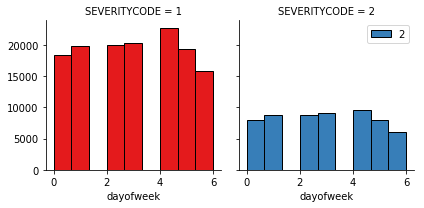

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Incident Date
df['INCDATE'] = pd.to_datetime(df['INCDATE'])
df.head()

df['dayofweek'] = df['INCDATE'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="SEVERITYCODE", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()




In [21]:
df.groupby([df['INCDATE'].dt.year]).agg({'mean'})

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY,PEDCOUNT_0,dayofweek
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
INCDATE,,,,,,,,,,,,,,,,,
2004,1.307375,-122.330285,47.621797,10962.043152,24691.625959,24691.625959,35093.770434,2.475769,0.030763,0.017362,1.980531,14.501643,4.176582e+06,0.000000,0.000000,0.029583,2.944543
2005,1.294410,-122.330435,47.620266,26375.441416,40390.871188,40390.871188,35157.794925,2.479656,0.029110,0.016937,1.989018,14.168905,5.189778e+06,0.000000,0.000000,0.028316,2.994707
2006,1.286410,-122.330843,47.620436,41934.029234,56336.934619,56336.934619,33333.283159,2.437187,0.032657,0.021398,1.978667,14.443245,6.182515e+06,0.000000,0.000000,0.031406,2.950948
2007,1.277878,-122.331270,47.620532,57103.706419,71826.342418,71826.359020,34294.128546,2.440232,0.032236,0.021029,1.979317,14.250623,7.183784e+06,251.828376,9589.865385,0.030645,2.971085
2008,1.275769,-122.332086,47.621816,71393.098023,86380.258858,86380.258858,34074.072935,2.427306,0.032138,0.023646,1.979649,13.997804,8.185052e+06,256.440556,10788.138141,0.030600,2.958053
2009,1.287881,-122.330611,47.620455,84832.673257,100152.512357,100152.652122,35918.008149,2.464633,0.035367,0.029061,1.968382,14.132606,9.180483e+06,387.297341,11166.049855,0.034004,2.976990
2010,1.300241,-122.330431,47.618903,98344.263601,114045.426906,114046.398409,36479.569853,2.521373,0.044504,0.031088,1.953460,14.288953,1.018696e+07,352.127591,14582.743431,0.042006,2.967894
2011,1.283817,-122.330885,47.620494,109083.254877,125105.249382,125105.767744,36827.734653,2.481821,0.034619,0.030589,1.959154,13.228409,1.118612e+07,347.689532,11571.979668,0.032604,2.929298


Some fascinating insights here:
    -Inattention spiked in 2013 and has never come back down. 
    -SDOT must have stopped giving classifiers in 2014, as most values after that date are null
    -People started suddenly hitting a lot of parked cars in 2015. Why?

Moving on to Junction Type

In [22]:
# Junction Type
df['JUNCTIONTYPE'].value_counts(dropna=False)

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
NaN                                                   6329
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

In [23]:
df.groupby(['JUNCTIONTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

JUNCTIONTYPE                                       SEVERITYCODE
At Intersection (but not related to intersection)  1               0.703051
                                                   2               0.296949
At Intersection (intersection related)             1               0.567362
                                                   2               0.432638
Driveway Junction                                  1               0.696936
                                                   2               0.303064
Mid-Block (but intersection related)               1               0.679816
                                                   2               0.320184
Mid-Block (not related to intersection)            1               0.783920
                                                   2               0.216080
Ramp Junction                                      1               0.674699
                                                   2               0.325301
Unknown                 

Its not clear there's anything happening with Junction Type

SDOT Collision codes

In [24]:
# SDOT Collision Codes
df['SDOT_COLCODE'].value_counts(dropna=False)

11    85209
14    54299
16     9928
0      9787
28     8856
24     6518
13     5852
26     4741
18     3104
15     1604
12     1440
51     1312
29      479
21      181
56      180
27      166
54      139
23      124
48      107
31      104
25      102
34       93
64       75
69       69
33       53
55       50
66       23
22       17
32       12
53        9
44        8
61        7
35        6
58        5
68        4
36        4
46        3
52        2
47        1
Name: SDOT_COLCODE, dtype: int64

In [25]:
df.groupby(['SDOT_COLCODE'])['SEVERITYCODE'].value_counts(normalize=True)

SDOT_COLCODE  SEVERITYCODE
0             1               0.927659
              2               0.072341
11            1               0.714373
              2               0.285627
12            1               0.981250
              2               0.018750
13            1               0.965995
              2               0.034005
14            1               0.673143
              2               0.326857
15            1               0.953242
              2               0.046758
16            1               0.930298
              2               0.069702
18            2               0.880799
              1               0.119201
21            2               0.773481
              1               0.226519
22            2               0.941176
              1               0.058824
23            2               0.750000
              1               0.250000
24            2               0.897975
              1               0.102025
25            1               0.80392

Lots of variety here, however we're also dealing with small sample sizes and an overload of categories. There is a potential unbalanced model concern with this variable

Inattention

In [26]:
# Inattention
df['INATTENTIONIND'].value_counts(dropna=False)

# Recode Nan/Y vars to 0/1
df['INATTENTIONIND'].replace(to_replace='Y', value=1, inplace=True)
df['INATTENTIONIND'] = df['INATTENTIONIND'].fillna(0)

df['INATTENTIONIND'].value_counts(dropna=False)

0.0    164868
1.0     29805
Name: INATTENTIONIND, dtype: int64

In [27]:
df.groupby(['INATTENTIONIND'])['SEVERITYCODE'].value_counts(normalize=True)

INATTENTIONIND  SEVERITYCODE
0.0             1               0.710126
                2               0.289874
1.0             1               0.651166
                2               0.348834
Name: SEVERITYCODE, dtype: float64

Inattentive drivers are only marginally more likely to cause bodily harm, though it does appear to be statistically significant.

What about drunk driving?

In [28]:
# Under Influence
df['UNDERINFL'].value_counts(dropna=False)

# Recode N/Y vars to 0/1
df['UNDERINFL'].replace(to_replace='N', value=0, inplace=True)
df['UNDERINFL'].replace(to_replace='0', value=0, inplace=True)
df['UNDERINFL'].replace(to_replace='Y', value=1, inplace=True)
df['UNDERINFL'].replace(to_replace='1', value=1, inplace=True)
df['UNDERINFL'] = df['UNDERINFL'].fillna(0)

df['UNDERINFL'].value_counts(dropna=False)

0.0    185552
1.0      9121
Name: UNDERINFL, dtype: int64

In [29]:
df.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True)

UNDERINFL  SEVERITYCODE
0.0        1               0.705603
           2               0.294397
1.0        1               0.609473
           2               0.390527
Name: SEVERITYCODE, dtype: float64

In [30]:
df[['UNDERINFL']].head()

,UNDERINFL
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


Yes, drunk drivers appear to be more likely to cause harm.

Does the weather matter?

In [31]:
# Weather
df['WEATHER'].value_counts(dropna=False)

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
NaN                           5081
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [32]:
df.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.732143
                          2               0.267857
Clear                     1               0.677509
                          2               0.322491
Fog/Smog/Smoke            1               0.671353
                          2               0.328647
Other                     1               0.860577
                          2               0.139423
Overcast                  1               0.684456
                          2               0.315544
Partly Cloudy             2               0.600000
                          1               0.400000
Raining                   1               0.662815
                          2               0.337185
Severe Crosswind          1               0.720000
                          2               0.280000
Sleet/Hail/Freezing Rain  1               0.752212
                          2               0.247788
Snowing                   1               0

Weather doesn't actually appear to make that much of a difference. We'll leave this one out of the model.

What about the road conditions? After all, that is more directly relevent to driving

In [33]:
# Road Conditions
df['ROADCOND'].value_counts(dropna=False)

Dry               124510
Wet                47474
Unknown            15078
NaN                 5012
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [34]:
df.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True)

ROADCOND        SEVERITYCODE
Dry             1               0.678227
                2               0.321773
Ice             1               0.774194
                2               0.225806
Oil             1               0.625000
                2               0.375000
Other           1               0.674242
                2               0.325758
Sand/Mud/Dirt   1               0.693333
                2               0.306667
Snow/Slush      1               0.833665
                2               0.166335
Standing Water  1               0.739130
                2               0.260870
Unknown         1               0.950325
                2               0.049675
Wet             1               0.668134
                2               0.331866
Name: SEVERITYCODE, dtype: float64

Some strange results here. For example "unknown" road conditions only have a 5% severity rate. I'm not sure what that could mean.

Let's move on to light conditions

In [35]:
# Light Conditions
df['LIGHTCOND'].value_counts(dropna=False)

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
NaN                           5170
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [36]:
df.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True)

LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   1               0.782694
                          2               0.217306
Dark - Street Lights Off  1               0.736447
                          2               0.263553
Dark - Street Lights On   1               0.701589
                          2               0.298411
Dark - Unknown Lighting   1               0.636364
                          2               0.363636
Dawn                      1               0.670663
                          2               0.329337
Daylight                  1               0.668116
                          2               0.331884
Dusk                      1               0.670620
                          2               0.329380
Other                     1               0.778723
                          2               0.221277
Unknown                   1               0.955095
                          2               0.044905
Name: SEVERITYCODE, dtype: float64

Again, it's not particularly clear.

Was right of way not granted?

In [37]:
# Right of way not granted?
df['PEDROWNOTGRNT'].value_counts(dropna=False)

# Recode N/Y vars to 0/1
df['PEDROWNOTGRNT'].replace(to_replace='Y', value=1, inplace=True)
df['PEDROWNOTGRNT'] = df['PEDROWNOTGRNT'].fillna(0)

df['PEDROWNOTGRNT'].value_counts(dropna=False)

0.0    190006
1.0      4667
Name: PEDROWNOTGRNT, dtype: int64

In [38]:
df.groupby(['PEDROWNOTGRNT'])['SEVERITYCODE'].value_counts(normalize=True)

PEDROWNOTGRNT  SEVERITYCODE
0.0            1               0.715898
               2               0.284102
1.0            2               0.901436
               1               0.098564
Name: SEVERITYCODE, dtype: float64

Winner winner chicken dinner. in 90% of cases where the right of way was not granted, there was an injury. This is likely tied into the type of collision.

Does speeding matter?

In [39]:
# Speeding
df['SPEEDING'].value_counts(dropna=False)

# Recode N/Y vars to 0/1
df['SPEEDING'].replace(to_replace='Y', value=1, inplace=True)
df['SPEEDING'] = df['SPEEDING'].fillna(0)

df['SPEEDING'].value_counts(dropna=False)

0.0    185340
1.0      9333
Name: SPEEDING, dtype: int64

In [40]:
df.groupby(['SPEEDING'])['SEVERITYCODE'].value_counts(normalize=True)

SPEEDING  SEVERITYCODE
0.0       1               0.705099
          2               0.294901
1.0       1               0.621665
          2               0.378335
Name: SEVERITYCODE, dtype: float64

It appears it matters, at least a little - speeders are 8 percentage points more likely to cause injuries

Does the State Collision Code matter?

In [41]:
# State Collision Code
df['ST_COLDESC'].value_counts(dropna=False)

One parked--one moving                                                                   44421
Entering at angle                                                                        34674
From same direction - both going straight - one stopped - rear-end                       25771
Fixed object                                                                             13554
From same direction - both going straight - both moving - sideswipe                      12777
From opposite direction - one left turn - one straight                                   10324
From same direction - both going straight - both moving - rear-end                        7629
NaN                                                                                       4904
Vehicle - Pedalcyclist                                                                    4701
From same direction - all others                                                          4537
From same direction - one left turn - one straight

In [42]:
df.groupby(['ST_COLDESC'])['SEVERITYCODE'].value_counts(normalize=True)

ST_COLDESC                                                                             SEVERITYCODE
All Other Multi Vehicle                                                                1               0.625000
                                                                                       2               0.375000
All other non-collision                                                                1               0.703704
                                                                                       2               0.296296
Breakage of any part of the vehicle resulting in injury or in further property damage  1               0.735294
                                                                                       2               0.264706
Domestic animal other (cat, dog, etc)                                                  1               0.937500
                                                                                       2               0.062500
Ente

Probably somewhat, but we're dealing with the same small sample size / too many categories issues that we dealt with with the SDOT data

Last but not least : Did the driver hit a parked car?

In [43]:
# Hit Parked Car
df['HITPARKEDCAR'].value_counts(dropna=False)

# Recode N/Y vars to 0/1
df['HITPARKEDCAR'].replace(to_replace='Y', value=1, inplace=True)
df['HITPARKEDCAR'].replace(to_replace='N', value=0, inplace=True)
df['HITPARKEDCAR'] = df['HITPARKEDCAR'].fillna(0)

df['HITPARKEDCAR'].value_counts(dropna=False)

0    187457
1      7216
Name: HITPARKEDCAR, dtype: int64

In [44]:
df.groupby(['HITPARKEDCAR'])['SEVERITYCODE'].value_counts(normalize=True)

HITPARKEDCAR  SEVERITYCODE
0             1               0.691983
              2               0.308017
1             1               0.937916
              2               0.062084
Name: SEVERITYCODE, dtype: float64

Clearly important. If you hit a parked car, you probably didn't do too much bodily harm. This will definitely go in the model.

Let's take another look at the raw data

In [45]:
df.head(10)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,PEDCOUNT_0,dayofweek
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,0.0,NaN,0.0,10,Entering at angle,0,0,0,0,2
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,0.0,6354039.0,0.0,11,From same direction - both going straight - bo...,0,0,0,0,2
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,0.0,4323031.0,0.0,32,One parked--one moving,0,0,0,0,3
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,0.0,NaN,0.0,23,From same direction - all others,0,0,0,0,4
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,0.0,4028032.0,0.0,10,Entering at angle,0,0,0,0,2
5,1,-122.387598,47.690575,6,320840,322340,E919477,Matched,Intersection,36974.0,...,0.0,NaN,0.0,10,Entering at angle,0,0,0,0,5
6,1,-122.338485,47.618534,7,83300,83300,3282542,Matched,Intersection,29510.0,...,0.0,8344002.0,0.0,10,Entering at angle,0,0,0,0,1
7,2,-122.320780,47.614076,9,330897,332397,EA30304,Matched,Intersection,29745.0,...,0.0,NaN,0.0,5,Vehicle Strikes Pedalcyclist,6855,0,0,0,2
8,1,-122.335930,47.611904,10,63400,63400,2071243,Matched,Block,NaN,...,0.0,6166014.0,0.0,32,One parked--one moving,0,0,0,0,3
9,2,-122.384700,47.528475,12,58600,58600,2072105,Matched,Intersection,34679.0,...,0.0,6079001.0,0.0,10,Entering at angle,0,0,0,0,0


### Data Preparation:
The data preparation includes all the required activities to construct the final dataset which will be fed into the modeling tools. Data preparation can be performed multiple times and it includes balancing the labeled data, transformation, filling missing data, and cleaning the dataset.

Based on the above analysis, the following variables seem important:<br><br>
Categorical<br>
ADDRTYPE<br>
COLLISIONTYPE<br>
ROADCOND<br><br>
Binary<br>
INATTENTIONIND<br>
UNDERINFL<br>
PEDROWNOTGRNT<br>
SPEEDING<br>
HITPARKEDCAR<br><br>
Numerical<br>
PEDCOUNT<br>
PERSONCOUNT<br>
PEDCYLCOUNT<br>
VEHCOUNT<br>

### Modeling:
In this phase, various algorithms and methods can be selected and applied to build the model including supervised machine learning techniques. You can select SVM, XGBoost, decision tree, or any other techniques. You can select a single or multiple machine learning models for the same data mining problem. At this phase, stepping back to the data preparation phase is often required.

In [46]:
df['SEVERITYCODE'].value_counts(dropna=False)

# Let's change the weighting to over-sample serious injuries

# Model for resampling
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.SEVERITYCODE==1]
df_minority = df[df.SEVERITYCODE==2]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=136485,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['SEVERITYCODE'].value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

2    136485
1    136485
Name: SEVERITYCODE, dtype: int64

In [47]:
Feature = df_upsampled[['INATTENTIONIND','UNDERINFL','PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR','PEDCOUNT','PEDCOUNT_0','PERSONCOUNT','PEDCYLCOUNT','VEHCOUNT']]




In [48]:
Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['ADDRTYPE'])], axis=1)
#Feature.drop(['Alley'], axis = 1,inplace=True)

Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['COLLISIONTYPE'])], axis=1)
#Feature.drop(['Angles'], axis = 1,inplace=True)

Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['ROADCOND'])], axis=1)
#Feature.drop(['Dry'], axis = 1,inplace=True)

Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['WEATHER'])], axis=1)
#Feature.drop(['Unknown'], axis = 1,inplace=True)

Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['LIGHTCOND'])], axis=1)
#Feature.drop(['Daylight'], axis = 1,inplace=True)

Feature = pd.concat([Feature,pd.get_dummies(df_upsampled['JUNCTIONTYPE'])], axis=1)
#Feature.drop(['Unknown'], axis = 1,inplace=True)


X = Feature
X[0:5]

,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,PEDCOUNT,PEDCOUNT_0,PERSONCOUNT,PEDCYLCOUNT,VEHCOUNT,...,Dusk,Other,Unknown,At Intersection (but not related to intersection),At Intersection (intersection related),Driveway Junction,Mid-Block (but intersection related),Mid-Block (not related to intersection),Ramp Junction,Unknown
1,0.0,0.0,0.0,0.0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0,0,0,4,0,3,...,0,0,0,0,0,0,0,1,0,0
3,0.0,0.0,0.0,0.0,0,0,0,3,0,3,...,0,0,0,0,0,0,0,1,0,0
5,0.0,0.0,0.0,0.0,0,0,0,2,0,2,...,0,0,0,0,1,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0,0,0,2,0,2,...,0,0,0,0,1,0,0,0,0,0


In [49]:
X.shape

(272970, 59)

In [50]:
# Drop any NaN values
X = X.dropna()
X.shape

(272970, 59)

In [51]:
# Normalize the X data
from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


array([[-0.43670817, -0.23070007, -0.1993071 , -0.23296354, -0.17180232,
        -0.23902672, -0.24502348, -0.42390388, -0.21526527,  0.14961355,
        -0.05634921,  0.79576403, -0.77730655, -0.49104226, -0.21369548,
        -0.10868854, -0.28744689, -0.36356721, -0.4819729 , -0.23852175,
        -0.49508953, -0.1191811 ,  3.37053891, -1.3692963 , -0.07654373,
        -0.01923905, -0.02618256, -0.01914353, -0.06763464, -0.02421753,
        -0.2502145 ,  1.71919409, -0.01624299, -1.18135873, -0.05318649,
        -0.05965566, -0.41202891, -0.00506404,  2.15287479, -0.01116115,
        -0.02329116, -0.06490199, -0.25105653, -0.08447238, -0.07753019,
         1.73231312, -0.0069012 , -0.11699637, -1.26266701, -0.17948233,
        -0.03322503, -0.23475833, -0.10461279, -0.75834319, -0.24130549,
        -0.36635788,  1.1638163 , -0.02891288, -0.00634816],
       [-0.43670817, -0.23070007, -0.1993071 , -0.23296354, -0.17180232,
        -0.23902672, -0.24502348,  1.45106944, -0.21526527,  1.

In [52]:
y = df_upsampled['SEVERITYCODE'].values

In [53]:
# Split the datasets into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.99, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2729, 59) (2729,)
Test set: (270241, 59) (270241,)


### Model 1: K Nearest Neighbor (KNN)

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [55]:
k = 8
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
yhat1 = neigh.predict(X_test)
yhat1[0:5]
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat1))

Train set Accuracy:  0.7237083180652254
Test set Accuracy:  0.6611395014080025


In [56]:
# Add a confusion matrix for KNN
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           1       0.64      0.75      0.69    135120
           2       0.70      0.57      0.63    135121

   micro avg       0.66      0.66      0.66    270241
   macro avg       0.67      0.66      0.66    270241
weighted avg       0.67      0.66      0.66    270241

Normalized confusion matrix
[[0.75 0.25]
 [0.43 0.57]]


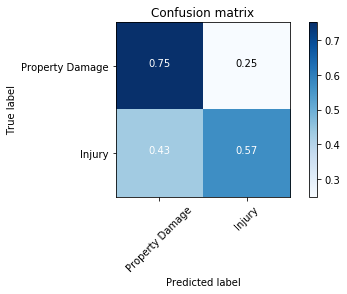

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, jaccard_similarity_score, f1_score

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat1)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

### Model 2: Decision Tree

In [58]:
from sklearn.tree import DecisionTreeClassifier

Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
Tree # it shows the default parameters

Tree.fit(X_train,y_train)

yhat2 = Tree.predict(X_test)

print (yhat2 [0:10])
print (y_test [0:10])

print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat2))

[1 1 2 1 1 1 2 2 2 1]
[1 1 2 1 1 2 2 2 2 1]
DecisionTrees's Accuracy:  0.6785646885557706


              precision    recall  f1-score   support

           1       0.64      0.80      0.71    135120
           2       0.74      0.55      0.63    135121

   micro avg       0.68      0.68      0.68    270241
   macro avg       0.69      0.68      0.67    270241
weighted avg       0.69      0.68      0.67    270241

Normalized confusion matrix
[[0.8  0.2 ]
 [0.45 0.55]]


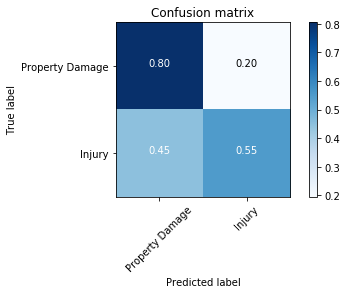

In [59]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat2)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat2))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

In [60]:
print(metrics.accuracy_score(y_test, yhat2))

0.6785646885557706
[1 2]


### Model 3: Support Vector Machine

In [61]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

yhat3 = clf.predict(X_test)
yhat3 [0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([1, 1, 2, 1, 1])

              precision    recall  f1-score   support

           1       0.73      0.63      0.68    135120
           2       0.67      0.77      0.72    135121

   micro avg       0.70      0.70      0.70    270241
   macro avg       0.70      0.70      0.70    270241
weighted avg       0.70      0.70      0.70    270241

Normalized confusion matrix
[[0.63 0.37]
 [0.23 0.77]]


0.6992906331755729

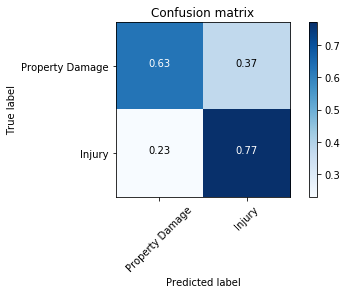

In [62]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat3)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat3))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

# F1 Score
f1_score(y_test, yhat3, average='weighted') 

# Jaccard
jaccard_similarity_score(y_test, yhat3)

### Model 4: Logistic Regression

[[ 85726  49394]
 [ 30481 104640]]
Normalized confusion matrix
[[0.63 0.37]
 [0.23 0.77]]
              precision    recall  f1-score   support

           1       0.74      0.63      0.68    135120
           2       0.68      0.77      0.72    135121

   micro avg       0.70      0.70      0.70    270241
   macro avg       0.71      0.70      0.70    270241
weighted avg       0.71      0.70      0.70    270241



0.5470091967665992

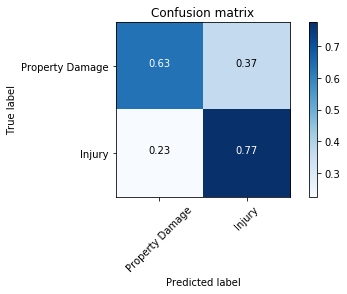

In [66]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

yhat4 = LR.predict(X_test)
yhat4

yhat4_prob = LR.predict_proba(X_test)
yhat4_prob

jaccard_similarity_score(y_test, yhat4)

#from sklearn.metrics import classification_report, confusion_matrix
#import itertools

print(confusion_matrix(y_test, yhat4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat4)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Property Damage','Injury'],normalize= True,  title='Confusion matrix')

print (classification_report(y_test, yhat4))


from sklearn.metrics import log_loss
log_loss(y_test, yhat4_prob)

### Evaluation:
Before proceeding to the deployment stage, the model needs to be evaluated thoroughly to ensure that the business or the applications' objectives are achieved. Certain metrics can be used for the model evaluation such as accuracy, recall, F1-score, precision, and others.

In [64]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

Evaluate KNN

In [67]:
# Evaluate KNN
print("KNN Evaluation set Accuracy: ", metrics.accuracy_score(y_test, yhat1))

# F1 Score
print("KNN Evaluation F1 Score: ", f1_score(y_test, yhat1, average='weighted'))

# Jaccard
print("KNN Evaluation Jaccard Score: ", jaccard_similarity_score(y_test, yhat1))

KNN Evaluation set Accuracy:  0.6611395014080025
KNN Evaluation F1 Score:  0.6583188775446457
KNN Evaluation Jaccard Score:  0.6611395014080025


Evaluate Decision Tree

In [68]:
# Evaluate Decision Tree
print("Decision Tree Evaluation set Accuracy: ", metrics.accuracy_score(y_test, yhat2))

# F1 Score
print("Decision Tree Evaluation F1 Score: ", f1_score(y_test, yhat2, average='weighted'))

# Jaccard
print("Decision Tree Evaluation Jaccard Score: ", jaccard_similarity_score(y_test, yhat2))

Decision Tree Evaluation set Accuracy:  0.6785646885557706
Decision Tree Evaluation F1 Score:  0.673356910370187
Decision Tree Evaluation Jaccard Score:  0.6785646885557706


Evaluate SVM

In [69]:
# Evaluate SVM
print("SVM Evaluation set Accuracy: ", metrics.accuracy_score(y_test, yhat3))

# F1 Score
print("SVM Evaluation F1 Score: ", f1_score(y_test, yhat3, average='weighted'))

# Jaccard
print("SVM Evaluation Jaccard Score: ", jaccard_similarity_score(y_test, yhat3))

SVM Evaluation set Accuracy:  0.6992906331755729
SVM Evaluation F1 Score:  0.6977633410513087
SVM Evaluation Jaccard Score:  0.6992906331755729


Evaluate Log Reg

In [70]:
yhat4_prob = LR.predict_proba(X_test)
print("LogReg Evaluation set Accuracy: ", metrics.accuracy_score(y_test, yhat4))

# F1 Score
print("LogReg Evaluation F1 Score: ", f1_score(y_test, yhat4, average='weighted'))

# Jaccard
print("LogReg Evaluation Jaccard Score: ", jaccard_similarity_score(y_test, yhat4))

# Log Loss
from sklearn.metrics import log_loss
print("LogReg Evaluation Log Loss Score: ", log_loss(y_test, yhat4_prob))

LogReg Evaluation set Accuracy:  0.7044304898220477
LogReg Evaluation F1 Score:  0.7029755883427451
LogReg Evaluation Jaccard Score:  0.7044304898220477
LogReg Evaluation Log Loss Score:  0.5470091967665992


### Deployment:
The deployment phase requirements vary from project to project. It can be as simple as creating a report, developing interactive visualization, or making the machine learning model available in the production environment. In this environment, the customers or end-users can utilize the model in different ways such as API, website, or so on.




import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import matplotlib.image as mpimg
import scipy.optimize as opt
from sklearn import tree



from sklearn.externals.six import StringIO



#


!conda install -c conda-forge python-graphviz -y
!conda install -c anaconda seaborn -y

%matplotlib inline 